- node 5개 실험

In [1]:
import numpy as np
from scipy.special import expit as sigmoid
import igraph as ig
import random
import argparse
import os
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

import data_generation as dg

In [12]:
n = random.choice([500, 1000])
d = 5
s0 = 1
graph_type = 'ER'
linear_sem_type = 'logistic'
nonlinear_sem_type = 'mlp'
sem_type = 'linear'
save_dir = '/home/jina/reprod/data/five'

In [ ]:
# for _ in range(2000):
#     dg.generate_data(n=n, d=d, s0=s0, graph_type=graph_type, linear_sem_type=linear_sem_type, nonlinear_sem_type=nonlinear_sem_type, type=sem_type, save_dir=save_dir)

000002


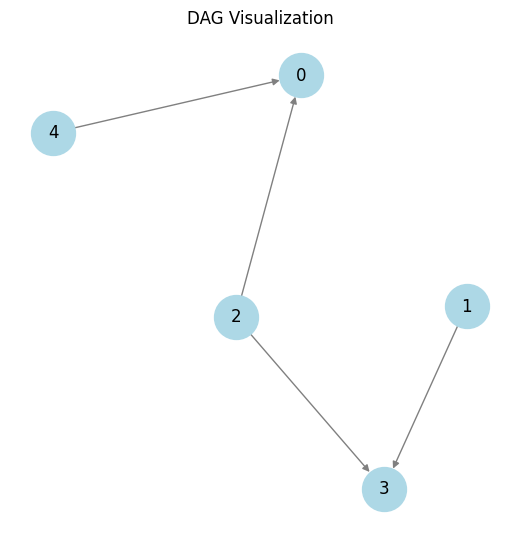

000007


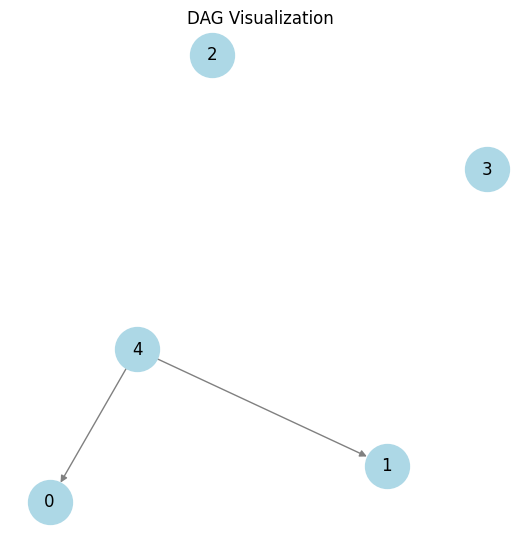

000009


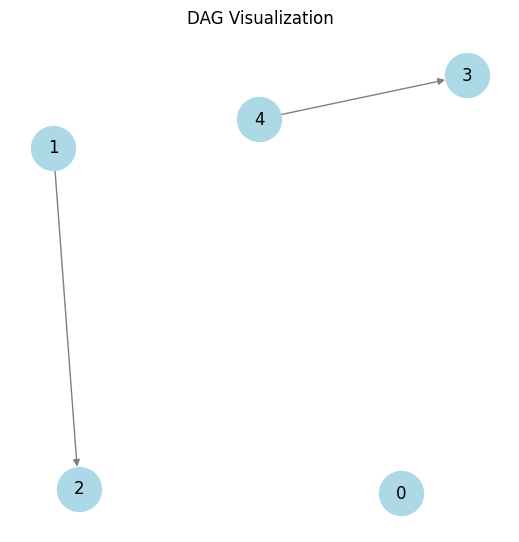

000006


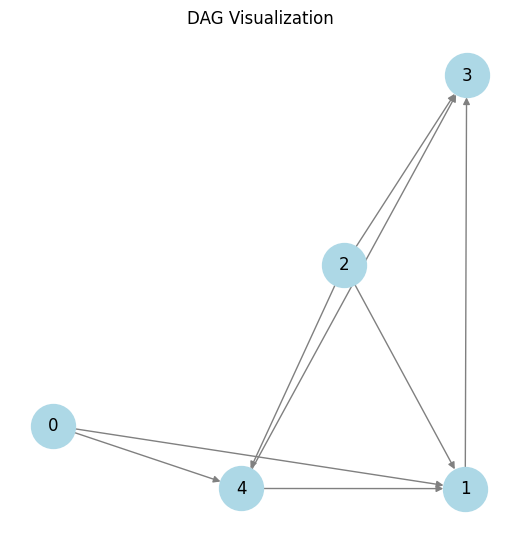

000003


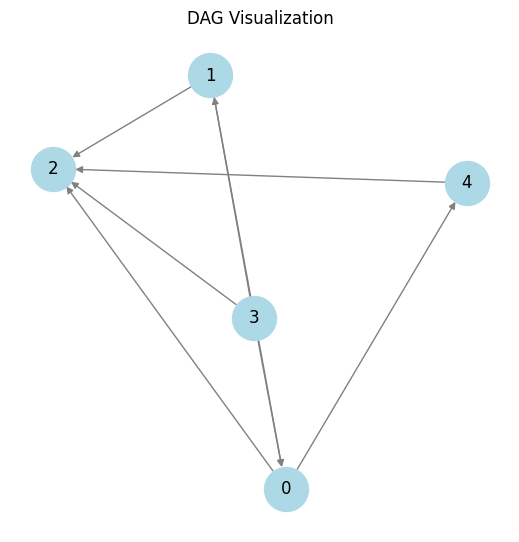

000005


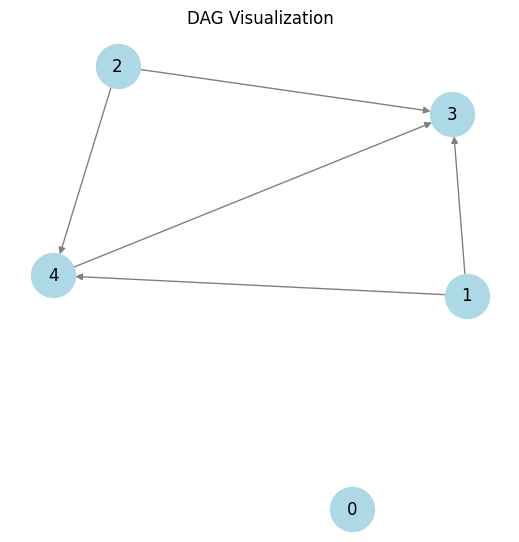

000008


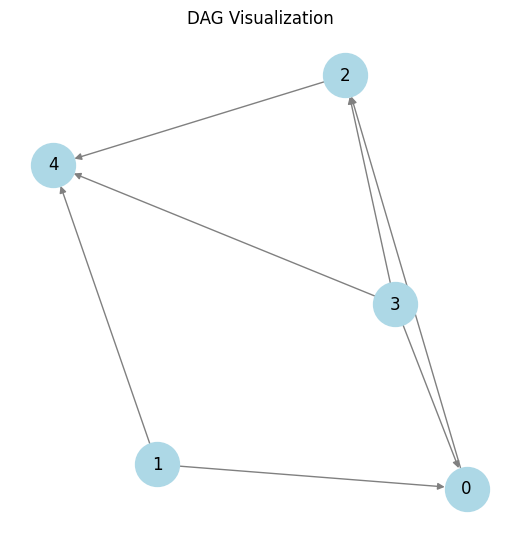

000004


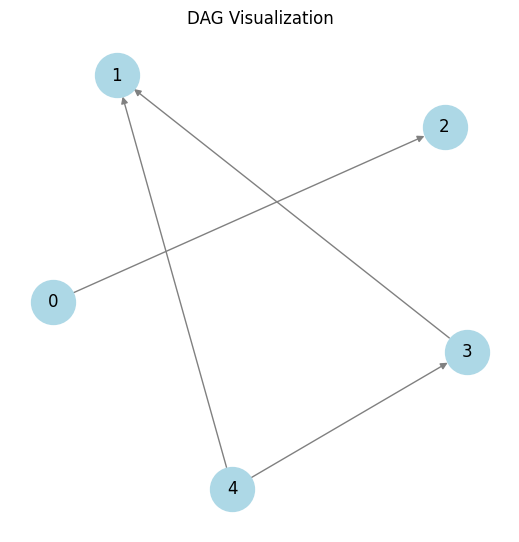

000001


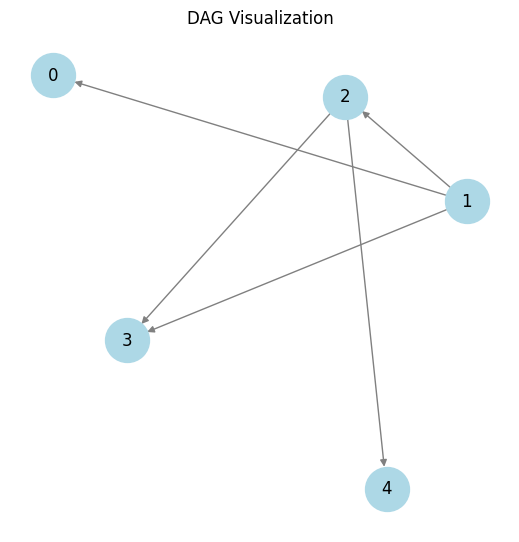

In [4]:
folder_path = save_dir
for files in os.listdir(folder_path):
    if files.startswith('00000'):
        print(files)
        file_path = os.path.join(save_dir, files)
        for csv in os.listdir(file_path):
            if csv.startswith('B_true'):
                csv_path = os.path.join(file_path, csv)
                dg.visualize_dag(csv_path)

In [ ]:
import pickle

pk = '/home/jina/reprod/data/pickle/five'
with open(pk, 'rb') as f:
    data = pickle.load(f)

# pk_v = '/home/jina/reprod/data/pickle/simple'
# with open(pk_v, 'rb') as f:
#     valid_data = pickle.load(f)

# train-test split
train_data = data[:800]
valid_data = data[800:]

In [11]:
import torch
import torch.nn as nn
from torch_geometric.loader import DataLoader
from model import GraphSAGE
from sklearn.metrics import f1_score
from collections import Counter

In [4]:
# Random seed setting
def seed_everything(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

In [5]:
import torch
import torch.nn as nn
from torch_geometric.loader import DataLoader
from model import GraphSAGE
from sklearn.metrics import f1_score
from collections import Counter

batch_size = 16
epochs = 20
num_layers = 5
lr = 0.0001
num_neighbor = 2
threshold = 0.5
# seed_everything(47)
seed_everything(4)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True)

loader_type = {
    "train": train_loader,
    "test": valid_loader
}

node_dim = train_data[0].x.size(1)
edge_dim = train_data[0].edge_attr.size(1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
model = GraphSAGE(node_dim, edge_dim, num_layers=num_layers, output_class=2, device=device, num_samples=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# criterion = nn.CrossEntropyLoss() 

best_test_f1 = 0
best_test_acc = 0
best_test_loss = 9999


for epoch in range(epochs):

    for mode in ["train", "test"]:
        running_loss = 0
        running_acc = 0
        total_samples = 0
        all_predictions = []
        all_labels = []

        if mode == 'train':
            model.train()
        elif mode == 'test':
            model.eval()
        
        for data in loader_type[mode]:
         
            data.x = data.x.float()
            data.y = data.y.long()

            data.y[data.y == 2] = 1

            # class_counts = Counter(data.y.numpy())
            # print(class_counts)
            # total_count = sum(class_counts.values())
            # print(total_count)
            # class_weights = {cls: total_count / count for cls, count in class_counts.items()}
            # weights = torch.tensor([class_weights[cls] for cls in range(3)], dtype=torch.float).to(device)

            data = data.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(mode == 'train'):
                logits = model(data)
                # if epoch == 9:
                #     print(torch.sigmoid(logits))
                preds = (torch.sigmoid(logits) > threshold).float()
                # pos_weight = torch.tensor([3.0]).to(device)
                # loss = focal_loss(logits, data.y.view(-1, 1).float())
                loss = nn.BCEWithLogitsLoss()(logits, data.y.view(-1, 1).float())
                # loss = nn.CrossEntropyLoss()(logits, data.y)
                # loss = nn.CrossEntropyLoss(weight=weights)(logits, data.y)
                # loss = F1Loss(classes=3)(logits, data.y)
                # loss = WeightedF1Loss(classes=3)(logits, data.y, class_weights=weights)
                
                # _, preds = torch.max(logits, 1)

                if mode == 'train':
                    loss.backward()
                    # 각 파라미터의 기울기를 출력
                    # print(f"Epoch {epoch}: Gradients")
                    # for name, param in model.named_parameters():
                    #     if param.grad is not None:
                    #         print(f"  Layer: {name} | Gradient Mean: {param.grad.mean()} | Gradient Std: {param.grad.std()}")
    
                    optimizer.step()


                all_predictions.extend(preds.cpu().numpy())
                all_labels.extend(data.y.cpu().numpy())

            running_loss += loss.item() * data.y.size(0)
            # print(torch.sum(preds == data.y), data.y.size(0))
            # running_acc += torch.sum(preds == data.y).item()
            running_acc += torch.sum(preds.squeeze() == data.y).item()
            total_samples += data.y.size(0)

        epoch_loss = running_loss / total_samples
        epoch_acc = running_acc / total_samples
        epoch_f1 = f1_score(all_labels, all_predictions, average='binary')
        print(f'epoch: {epoch+1}, {mode} loss: {epoch_loss:.3f}, acc: {epoch_acc:.3f} f1: {epoch_f1:.3f}')

        if mode == 'test' and best_test_f1 < epoch_f1:
            best_test_f1 = epoch_f1

        if mode == 'test' and best_test_acc < epoch_acc:
            best_test_acc = epoch_acc

        if mode == 'test' and best_test_loss > epoch_loss:
            # file_name = f'epoch{epoch+1:04d}_{str(epoch_loss)[:5].replace(".","")}'
            # save_model(model, saved_dir, f'{file_name}.pth')
            best_test_loss = epoch_loss

print("training end!!")
print(f"best f1: {best_test_f1}, best acc: {best_test_acc}, best loss: {best_test_loss}")

epoch: 1, train loss: 0.691, acc: 0.503 f1: 0.008
epoch: 1, test loss: 0.686, acc: 0.498 f1: 0.013
epoch: 2, train loss: 0.669, acc: 0.688 f1: 0.650
epoch: 2, test loss: 0.643, acc: 0.757 f1: 0.768
epoch: 3, train loss: 0.614, acc: 0.720 f1: 0.743
epoch: 3, test loss: 0.571, acc: 0.757 f1: 0.778
epoch: 4, train loss: 0.566, acc: 0.742 f1: 0.758
epoch: 4, test loss: 0.530, acc: 0.773 f1: 0.781
epoch: 5, train loss: 0.543, acc: 0.746 f1: 0.757
epoch: 5, test loss: 0.506, acc: 0.777 f1: 0.789
epoch: 6, train loss: 0.526, acc: 0.758 f1: 0.767
epoch: 6, test loss: 0.487, acc: 0.792 f1: 0.798
epoch: 7, train loss: 0.532, acc: 0.760 f1: 0.768
epoch: 7, test loss: 0.483, acc: 0.800 f1: 0.806
epoch: 8, train loss: 0.532, acc: 0.746 f1: 0.757
epoch: 8, test loss: 0.482, acc: 0.793 f1: 0.803
epoch: 9, train loss: 0.517, acc: 0.770 f1: 0.778
epoch: 9, test loss: 0.474, acc: 0.792 f1: 0.807
epoch: 10, train loss: 0.500, acc: 0.783 f1: 0.792
epoch: 10, test loss: 0.465, acc: 0.803 f1: 0.810
epoch: 1

In [6]:
for a, b in zip(all_predictions, all_labels):
    print(a, b)

[0.] 0
[0.] 0
[0.] 0
[0.] 0
[0.] 0
[0.] 0
[0.] 0
[0.] 0
[0.] 0
[1.] 1
[1.] 1
[1.] 1
[1.] 0
[1.] 1
[1.] 1
[0.] 0
[0.] 0
[1.] 1
[0.] 0
[0.] 0
[1.] 1
[1.] 1
[1.] 1
[1.] 0
[1.] 1
[1.] 0
[1.] 1
[0.] 0
[0.] 0
[1.] 1
[1.] 1
[0.] 0
[1.] 0
[0.] 0
[0.] 0
[1.] 1
[1.] 1
[1.] 0
[1.] 1
[0.] 0
[0.] 1
[0.] 0
[0.] 0
[0.] 0
[0.] 0
[1.] 1
[1.] 1
[1.] 0
[1.] 1
[1.] 1
[1.] 1
[0.] 1
[0.] 0
[0.] 0
[1.] 1
[1.] 1
[1.] 1
[0.] 1
[0.] 0
[0.] 0
[1.] 0
[1.] 1
[1.] 1
[0.] 0
[0.] 0
[1.] 1
[1.] 1
[1.] 0
[1.] 1
[0.] 1
[0.] 0
[0.] 0
[1.] 1
[1.] 1
[1.] 0
[1.] 1
[1.] 1
[1.] 0
[1.] 1
[1.] 0
[1.] 1
[1.] 1
[1.] 1
[1.] 1
[1.] 1
[0.] 0
[0.] 0
[1.] 1
[0.] 0
[0.] 0
[1.] 1
[0.] 0
[0.] 0
[0.] 0
[0.] 0
[1.] 1
[1.] 1
[0.] 0
[0.] 0
[0.] 0
[0.] 0
[0.] 0
[1.] 1
[1.] 1
[1.] 1
[0.] 0
[0.] 0
[0.] 0
[1.] 0
[1.] 0
[1.] 1
[1.] 1
[1.] 0
[1.] 1
[1.] 0
[1.] 1
[1.] 1
[0.] 0
[0.] 0
[1.] 1
[1.] 1
[1.] 0
[1.] 1
[0.] 0
[0.] 0
[0.] 0
[0.] 0
[0.] 0
[1.] 1
[0.] 1
[0.] 0
[0.] 0
[1.] 1
[1.] 1
[1.] 0
[0.] 1
[1.] 1
[0.] 0
[0.] 0
[0.] 0
[1.] 1
[1.] 1
[1.] 1

In [7]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# 정확도 계산
accuracy = accuracy_score(all_labels, all_predictions)

# F1 점수 계산 (binary classification이므로 average='binary')
f1 = f1_score(all_labels, all_predictions)

# 혼동 행렬 계산
tn, fp, fn, tp = confusion_matrix(all_labels, all_predictions).ravel()

# 결과 출력
print(f"Accuracy: {accuracy:}")
print(f"F1 Score: {f1:}")
print("Confusion Matrix:")
print(tn, fp, fn, tp)


Accuracy: 0.8283333333333334
F1 Score: 0.8377952755905512
Confusion Matrix:
231 66 37 266


In [8]:
import pickle

pk_v = '/home/jina/reprod/data/pickle/simple3'
with open(pk_v, 'rb') as f:
    test_data = pickle.load(f)



In [9]:

batch_size = 4
epochs = 1
num_layers = 3
lr = 0.0001
num_neighbor = 2
threshold = 0.5
# seed_everything(47)
seed_everything(4)

# train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
# valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size)

loader_type = {
    # "train": train_loader,
    "test": test_loader
}

node_dim = test_data[0].x.size(1)
edge_dim = test_data[0].edge_attr.size(1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = GraphSAGE(node_dim, edge_dim, num_layers=num_layers, output_class=2, device=device, num_samples=None).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)


best_test_f1 = 0
best_test_acc = 0
best_test_loss = 9999


for epoch in range(epochs):

    for mode in ["test"]:
        running_loss = 0
        running_acc = 0
        total_samples = 0
        all_predictions = []
        all_labels = []

        model.eval()
        
        for data in loader_type[mode]:
         
            data.x = data.x.float()
            data.y = data.y.long()

            data.y[data.y == 2] = 1
            data = data.to(device)

            logits = model(data)
            preds = (torch.sigmoid(logits) > threshold).float()
            loss = nn.BCEWithLogitsLoss()(logits, data.y.view(-1, 1).float())

            all_predictions.extend(preds.cpu().numpy())
            all_labels.extend(data.y.cpu().numpy())

            running_loss += loss.item() * data.y.size(0)
            running_acc += torch.sum(preds.squeeze() == data.y).item()
            total_samples += data.y.size(0)

        epoch_loss = running_loss / total_samples
        epoch_acc = running_acc / total_samples
        epoch_f1 = f1_score(all_labels, all_predictions, average='binary')
        print(f'epoch: {epoch+1}, {mode} loss: {epoch_loss:.3f}, acc: {epoch_acc:.3f} f1: {epoch_f1:.3f}')

        if mode == 'test' and best_test_f1 < epoch_f1:
            best_test_f1 = epoch_f1

        if mode == 'test' and best_test_acc < epoch_acc:
            best_test_acc = epoch_acc

        if mode == 'test' and best_test_loss > epoch_loss:
            best_test_loss = epoch_loss

print("training end!!")
print(f"best f1: {best_test_f1}, best acc: {best_test_acc}, best loss: {best_test_loss}")

epoch: 1, test loss: 0.367, acc: 0.857 f1: 0.871
training end!!
best f1: 0.8710493046776233, best acc: 0.8572, best loss: 0.3666402714401484


In [12]:
for a, b in zip(all_predictions, all_labels):
    print(a, b)

[1.] 1
[1.] 0
[1.] 1
[1.] 1
[1.] 1
[0.] 0
[1.] 1
[1.] 1
[1.] 1
[1.] 1
[1.] 1
[1.] 0
[1.] 1
[1.] 1
[1.] 1
[1.] 1
[1.] 0
[0.] 0
[0.] 0
[0.] 0
[1.] 1
[1.] 1
[1.] 1
[0.] 0
[1.] 1
[1.] 1
[0.] 0
[1.] 1
[1.] 1
[1.] 1
[1.] 1
[1.] 0
[1.] 1
[1.] 1
[0.] 0
[1.] 0
[0.] 0
[1.] 0
[1.] 1
[1.] 0
[1.] 1
[0.] 0
[0.] 0
[0.] 0
[1.] 0
[1.] 1
[1.] 0
[1.] 1
[1.] 1
[1.] 1
[0.] 0
[0.] 0
[1.] 1
[0.] 0
[0.] 0
[1.] 0
[1.] 1
[1.] 1
[1.] 1
[1.] 1
[1.] 0
[1.] 0
[1.] 1
[1.] 1
[1.] 1
[1.] 0
[1.] 1
[1.] 0
[1.] 0
[1.] 1
[1.] 1
[1.] 1
[1.] 0
[1.] 1
[1.] 1
[1.] 1
[0.] 0
[0.] 0
[1.] 1
[0.] 0
[0.] 0
[1.] 0
[1.] 1
[0.] 0
[1.] 1
[1.] 1
[0.] 0
[0.] 1
[0.] 0
[1.] 1
[1.] 0
[0.] 0
[0.] 0
[1.] 1
[1.] 1
[1.] 1
[1.] 1
[1.] 1
[0.] 0
[1.] 1
[1.] 0
[1.] 0
[0.] 0
[1.] 1
[1.] 1
[1.] 1
[1.] 0
[0.] 0
[0.] 0
[1.] 0
[0.] 0
[1.] 1
[1.] 1
[0.] 0
[0.] 0
[1.] 1
[1.] 1
[1.] 1
[0.] 0
[1.] 1
[1.] 1
[0.] 0
[1.] 1
[1.] 1
[0.] 0
[0.] 0
[0.] 0
[1.] 1
[1.] 1
[1.] 1
[0.] 0
[0.] 0
[1.] 1
[0.] 0
[0.] 0
[0.] 0
[0.] 0
[1.] 1
[1.] 0
[1.] 1
[1.] 1
[0.] 0
[1.] 1

In [13]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# 정확도 계산
accuracy = accuracy_score(all_labels, all_predictions)

# F1 점수 계산 (binary classification이므로 average='binary')
f1 = f1_score(all_labels, all_predictions)

# 혼동 행렬 계산
tn, fp, fn, tp = confusion_matrix(all_labels, all_predictions).ravel()

# 결과 출력
print(f"Accuracy: {accuracy:}")
print(f"F1 Score: {f1:}")
print("Confusion Matrix:")
print(tn, fp, fn, tp)


Accuracy: 0.8491
F1 Score: 0.8662115435765582
Confusion Matrix:
3606 1412 97 4885


In [19]:
test_data[0].y

tensor([0.], device='cuda:0')

In [18]:
torch.sigmoid(model(test_data[0].to(device)))

tensor([[0.0206]], device='cuda:0', grad_fn=<SigmoidBackward0>)